In [3]:
%load_ext autoreload

%autoreload 2

In [12]:
from itertools import combinations_with_replacement, product

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from joblib import Parallel, delayed
from tqdm.auto import tqdm

import qcheff
from qcheff.duffing.duffing_chain_utils import duffing_chain_num_ham

rng = np.random.default_rng()

import matplotlib as mpl
from matplotlib.colors import LogNorm

from qcheff.duffing.duffing_chain_utils import create_duffing_chain_zz_system
from qcheff.npad.sparse.npad_cpu import (
    npad_decouple,
    npad_diagonalize,
    npad_eliminate_couplings,
)

mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["font.size"] = 25
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["lines.markersize"] = 8
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["axes.titlesize"] = 20


def plot_matelm_mag(H: np.ndarray, scale="log"):
    fig, ax = plt.subplots(1, 1, layout="constrained")
    absH = np.abs(H)
    P1 = ax.imshow(
        absH, cmap="binary", norm=LogNorm(vmin=1e-10) if scale == "log" else None
    )
    ax.set(xticks=[], yticks=[])
    plt.colorbar(P1, ax=ax)


def plot_offdiag_mag(H: np.ndarray, scale="log"):
    plot_matelm_mag(H - np.diag(np.diagonal(H)), scale=scale)

# Duffing Chain ZZ Example NPAD
We will estimate the zz coupling between the qubits at the two ends of a linear spin chain.

There are 3^5 = 243 levels in this chain of size 5. We only care about the levels contributing to ZZ interaction for the end qubits. there are 4 such levels.
We should partition them out.

In [38]:
global_chain_size = 4
global_ntrunc = 3
system_dims = [global_ntrunc] * global_chain_size
all_levels = list(qt.state_number_enumerate(system_dims))
# Keeping levels with 0 or 1 excitations at the ends, and 0 excitations in the middle
end_zz_levels = [
    label
    for label in all_levels
    if label[0] in [0, 1] and label[-1] in [0, 1] and set(label[1:-1]) == {0}
]
# qubit_chain_levels = [label for label in all_levels if max(label) <= 1]
other_levels = [label for label in all_levels if label not in end_zz_levels]
end_zz_idx = np.asarray(
    [qt.state_number_index(system_dims, state) for state in end_zz_levels]
)
other_idx = np.asarray(
    [qt.state_number_index(system_dims, state) for state in other_levels]
)

In [39]:
end_zz_states = [qt.basis(system_dims, list(level)) for level in end_zz_levels]

In [40]:
end_zz_idx

array([ 0,  1, 27, 28])

In [41]:
end_zz_levels

[(0, 0, 0, 0), (0, 0, 0, 1), (1, 0, 0, 0), (1, 0, 0, 1)]

In [42]:
def get_n_photon_couplings(n: int):
    pm_gens = np.asarray(
        np.identity(global_chain_size) - np.diag(np.ones(global_chain_size - 1), k=1),
        dtype=int,
    )[:-1]
    mp_gens = -pm_gens
    all_1p_gens = np.vstack([pm_gens, mp_gens])
    all_np_gens = np.vstack(
        [sum(gens) for gens in combinations_with_replacement(all_1p_gens, n)]
    )
    fstates = np.vstack(end_zz_levels)[:, None, :] + all_np_gens
    istates = np.broadcast_to(np.vstack(end_zz_levels)[:, None, :], fstates.shape)

    coupling_tuples = [
        (istate, fstate)
        for istate, fstate in zip(np.vstack(istates), np.vstack(fstates), strict=False)
        if np.all(fstate >= 0)
        and np.all(fstate < global_ntrunc)
        and not np.all(fstate == 0)
    ]

    coupling_idx = np.asarray(
        [
            (
                qt.state_number_index(system_dims, i),
                qt.state_number_index(system_dims, j),
            )
            for i, j in coupling_tuples
            if (i - j).any()
        ]
    )
    return np.unique(coupling_idx, axis=0)


get_n_photon_couplings(7)

array([[ 1,  3],
       [ 1, 27],
       [27,  1],
       [27,  9],
       [28,  2],
       [28,  6],
       [28, 10],
       [28, 18],
       [28, 30],
       [28, 54]])

Now that we have identified labels for each set of levels, we first decouple, then diagonalize.).

In [77]:
def create_test_ham(delp, delm):
    test_sys = create_duffing_chain_zz_system(
        chain_size=global_chain_size,
        delp=delp,
        delm=delm,
        ntrunc=global_ntrunc,
    )

    test_ham = duffing_chain_num_ham(test_sys)
    return test_ham


def numerical_zz(delp, delm, debug=False):
    test_ham = create_test_ham(delp, delm)
    test_evals, test_esys = qt.Qobj(test_ham).eigenstates()
    overlap_mat = np.asarray(
        [
            np.abs(test_estate.overlap(state)) ** 2
            for state, test_estate in product(end_zz_states, test_esys)
        ]
    ).reshape(4, -1)
    E00, E01, E10, E11 = test_evals[np.argmax(overlap_mat, axis=1)]
    if debug:
        print(f"E00: {E00}, E01: {E01}, E10: {E10}, E11: {E11}")
    return E00 + E11 - E01 - E10


def npad_auto_chain_zz(delp, delm, eps=1e-5, debug=False):
    test_ham = create_test_ham(delp, delm)
    # npad_cz_ham = npad_diagonalize(test_ham, eps=1e-9)[np.ix_(end_zz_idx, end_zz_idx)]
    npad_cz_ham = npad_diagonalize(
        npad_decouple(
            test_ham,
            incl_idx=end_zz_idx,
            excl_idx=other_idx,
            eps=eps,
        )[np.ix_(end_zz_idx, end_zz_idx)],
        eps=eps,
    )
    E00, E01, E10, E11 = npad_cz_ham.diagonal()
    if debug:
        print(f"E00: {E00}, E01: {E01}, E10: {E10}, E11: {E11}")
    return E11 + E00 - E01 - E10


def npad_heuristic_chain_zz(delp, delm, debug=False):
    test_ham = create_test_ham(delp, delm)
    # This can get really slow.
    coupling_batches = [get_n_photon_couplings(n) for n in range(1, global_chain_size)]
    for batch in coupling_batches:
        test_ham = npad_eliminate_couplings(test_ham, batch)
    npad_cz_ham = npad_diagonalize(test_ham[np.ix_(end_zz_idx, end_zz_idx)], eps=1e-12)
    E00, E01, E10, E11 = npad_cz_ham.diagonal()
    if debug:
        print(f"E00: {E00}, E01: {E01}, E10: {E10}, E11: {E11}")
    return E11 + E00 - E01 - E10


print(
    npad_auto_chain_zz(0.1, 0.3, debug=True),
    npad_heuristic_chain_zz(0.1, 0.3, debug=True),
    numerical_zz(0.1, 0.3, debug=True),
)

E00: 0j, E01: (2.8757016914706464+0j), E10: (3.212482848468841+0j), E11: (6.105731064323133+0j)
E00: 0j, E01: (2.8757470693216227+0j), E10: (3.2124828757158066+0j), E11: (6.094907830298056+0j)
E00: 0.0, E01: 2.8756957352397157, E10: 3.2124838975596823, E11: 6.090464626203605
(0.01754652438364568+0j) (0.006677885260626848+0j) 0.0022849934042072917


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Finished NPAD


[Text(0.5, 0, '$\\Delta_+$ (GHz)'),
 Text(0, 0.5, '$|(\\tilde{\\zeta} - \\zeta)/\\zeta|$ (GHz)')]

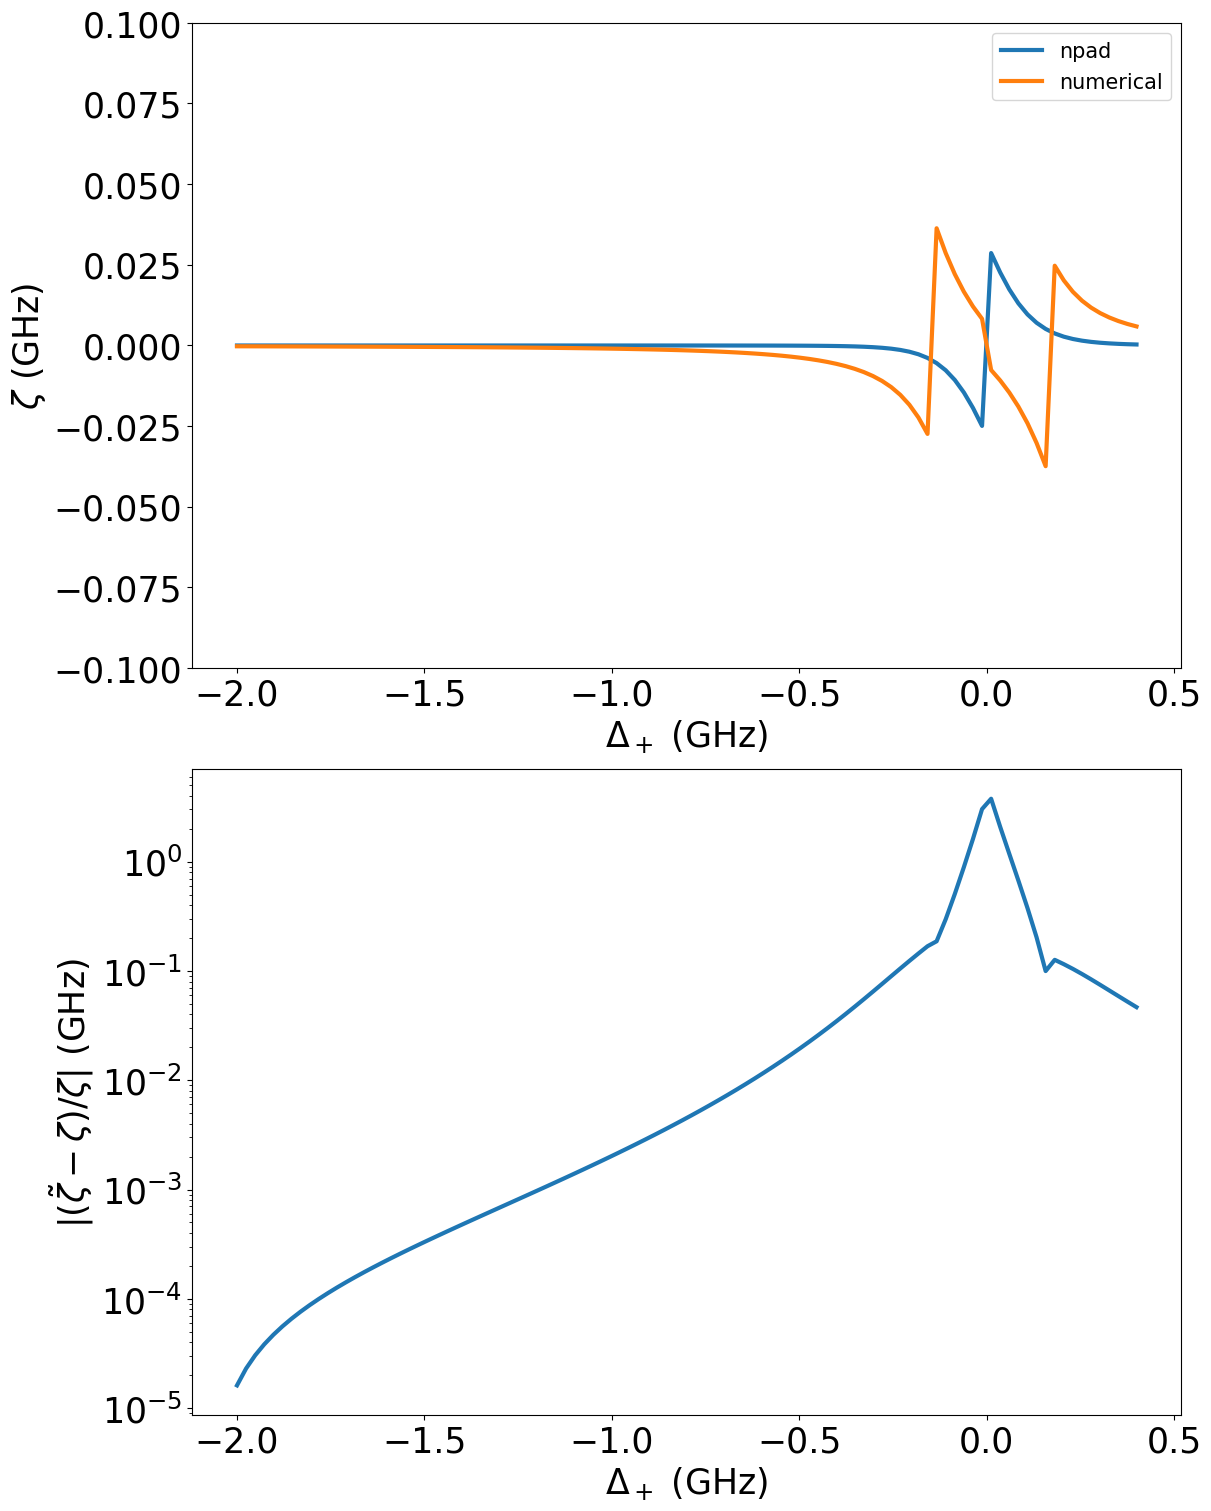

In [44]:
N = 100
delp_list = np.linspace(-2.0, 0.4, N)
delm = 0.00


numerical_zz_list = np.vstack(
    list(
        tqdm(
            Parallel(n_jobs=-2, verbose=0, return_as="generator")(
                delayed(numerical_zz)(delp, delm) for delp in delp_list
            ),
            total=N,
        )
    )
)

npad_auto_chain_zz_list = np.vstack(
    list(
        tqdm(
            Parallel(n_jobs=-2, verbose=0, return_as="generator")(
                delayed(npad_heuristic_chain_zz)(delp, delm) for delp in delp_list
            ),
            total=N,
        )
    )
)
print("Finished NPAD")

fig, (zz_ax, err_ax) = plt.subplots(2, 1, figsize=(12, 15), layout="constrained")
zz_ax.plot(delp_list, npad_auto_chain_zz_list, label="npad")
zz_ax.plot(delp_list, numerical_zz_list, label="numerical")
zz_ax.legend()
zz_ax.set(
    xlabel=r"$\Delta_+$ (GHz)",
    ylabel=r"$\zeta$ (GHz)",
    ylim=(-0.1, 0.1),
)
zz_ax.set(
    xlabel=r"$\Delta_+$ (GHz)",
    ylabel=r"$\zeta$ (GHz)",
)
err_ax.semilogy(
    delp_list, np.abs(numerical_zz_list - npad_auto_chain_zz_list / numerical_zz_list)
)
err_ax.set(
    xlabel=r"$\Delta_+$ (GHz)",
    ylabel=r"$|(\tilde{\zeta} - \zeta)/\zeta|$ (GHz)",
)

In [45]:
import scipy.sparse as spsparse

In [46]:
from qcheff.npad.sparse.npad_cpu import (
    npad_eliminate_coupling,
    npad_eliminate_largest_coupling,
)

In [47]:
H_sys = create_test_ham(0.1, 0.5)
H_diag = npad_decouple(
    H=H_sys,
    incl_idx=end_zz_idx,
    excl_idx=other_idx,
    eps=1e-10,
    max_rots=int(2e4),
    # debug=True,
)

assert np.allclose(
    qt.Qobj(H_diag).eigenenergies(), qt.Qobj(H_sys).eigenenergies()
), "Output matrix has wrong eigenvalues."

In [56]:
(np.abs(H_diag[np.ix_(end_zz_idx, other_idx)]).max())

1.894955273485343e-08

In [70]:
np.abs(-qt.Qobj(H_sys).eigenenergies())

array([0.00000000e+00, 8.88178420e-16, 3.10862447e-15, 1.33226763e-15,
       1.33226763e-15, 0.00000000e+00, 1.77635684e-15, 1.77635684e-15,
       8.88178420e-16, 3.55271368e-15, 4.08562073e-14, 3.19744231e-14,
       5.32907052e-15, 7.10542736e-15, 8.88178420e-16, 0.00000000e+00,
       1.77635684e-15, 1.77635684e-15, 3.55271368e-15, 5.32907052e-15,
       1.77635684e-15, 3.55271368e-15, 8.88178420e-15, 7.10542736e-15,
       0.00000000e+00, 1.59872116e-14, 0.00000000e+00, 0.00000000e+00,
       1.24344979e-14, 0.00000000e+00, 5.32907052e-15, 1.77635684e-15,
       3.55271368e-15, 5.32907052e-15, 8.88178420e-15, 3.55271368e-15,
       7.10542736e-15, 5.32907052e-15, 7.10542736e-15, 1.77635684e-15,
       1.77635684e-15, 3.55271368e-15, 1.06581410e-14, 1.95399252e-14,
       1.77635684e-15, 7.10542736e-15, 5.32907052e-15, 7.10542736e-15,
       7.10542736e-15, 8.88178420e-15, 1.42108547e-14, 1.24344979e-14,
       1.42108547e-14, 3.55271368e-15, 1.77635684e-15, 1.77635684e-15,
      

# Problem: labeling

Clearly there is some kind of labeling problem? let's compare the eigenvalues as labeled by both methods

In [48]:
from scipy import sparse
from scipy.spatial import distance

In [72]:
def compare_eigenvalue_error(delp, delm, eps=1e-5):
    H_sys = create_test_ham(delp, delm)
    H_diag = npad_decouple(
        H=H_sys,
        incl_idx=end_zz_idx,
        excl_idx=other_idx,
        eps=1e-10,
        max_rots=int(2e4),
        # debug=True,
    )
    return distance.euclidean(
        np.sort(
            np.concatenate(
                [
                    qt.Qobj(H_diag[np.ix_(end_zz_idx, end_zz_idx)]).eigenenergies(),
                    qt.Qobj(H_diag[np.ix_(other_idx, other_idx)]).eigenenergies(),
                ]
            )
        ),
        qt.Qobj(H_sys).eigenenergies(),
    )
    # return distance.euclidean(qt.Qobj(H_diag).eigenenergies(), qt.Qobj(H_sys).eigenenergies())

In [73]:
compare_eigenvalue_error(0.1, 0.5)

1.171310020804805e-13

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Total Spectrum Error')

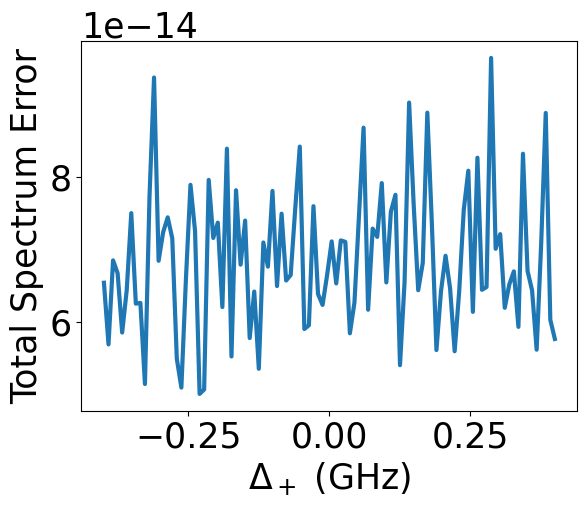

In [75]:
delp_list = np.linspace(-0.4, 0.4, N)
err_list = [compare_eigenvalue_error(delp, 0) for delp in tqdm(delp_list)]
plt.plot(delp_list, err_list)
plt.xlabel(r"$\Delta_+$ (GHz)")
plt.ylabel("Total Spectrum Error")

This tells us that NPAD doesn't change the spectrum overall. Next, we should check if the eigenvalues of the ZZ subspace are the same in either case.

In [ ]:
def compare_eigenvalue_error_ZZ(delp, delm, eps=1e-5, debug=False):
    H_sys = create_test_ham(delp, delm)
    npad_cz_ham = npad_diagonalize(
        # npad_decouple(
        H_sys,
        # incl_idx=end_zz_idx,
        # excl_idx=other_idx,
        max_rots=int(2e4),
        eps=eps,
    )[np.ix_(end_zz_idx, end_zz_idx)]  # ,
    # eps=eps,
    # )
    E00_npad, E01_npad, E10_npad, E11_npad = npad_cz_ham.diagonal()
    if debug:
        print(f"E00: {E00_npad}, E01: {E01_npad}, E10: {E10_npad}, E11: {E11_npad}")
    test_evals, test_esys = qt.Qobj(H_sys).eigenstates()
    overlap_mat = np.asarray(
        [
            np.abs(test_estate.overlap(state)) ** 2
            for state, test_estate in product(end_zz_states, test_esys)
        ]
    ).reshape(4, -1)
    E00_diag, E01_diag, E10_diag, E11_diag = test_evals[np.argmax(overlap_mat, axis=1)]
    if debug:
        print(f"E00: {E00_diag}, E01: {E01_diag}, E10: {E10_diag}, E11: {E11_diag}")
    delta_E00 = np.abs(E00_npad - E00_diag)
    delta_E01 = np.abs(E01_npad - E01_diag)
    delta_E10 = np.abs(E10_npad - E10_diag)
    delta_E11 = np.abs(E11_npad - E11_diag)
    if debug:
        print(
            f"delta_E00: {delta_E00}, delta_E01: {delta_E01}, delta_E10: {delta_E10}, delta_E11: {delta_E11}"
        )
    return [delta_E00, delta_E01, delta_E10, delta_E11]

In [ ]:
delp_list = np.linspace(-0.4, 0.4, N)
err_list = [compare_eigenvalue_error_ZZ(delp, 0) for delp in tqdm(delp_list)]
plt.plot(delp_list, err_list)
plt.legend(["E00", "E01", "E10", "E11"])

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Could not diagonalize matrix

In [ ]:
compare_eigenvalue_error_ZZ(0.1, 0, debug=True)

In [ ]:
def spectrum_error_vs_rotation(delp, delm, max_rots=200, debug=False):
    H_sys = create_test_ham(delp, delm)
    true_spectrum = np.sort(qt.Qobj(H_sys).eigenenergies())
    dist_list = np.zeros(max_rots)
    norm_list = np.zeros(max_rots)
    for i in tqdm(range(max_rots), disable=not debug):
        H_sys = npad_eliminate_largest_coupling(H_sys)
        dist_list[i] = distance.euclidean(np.sort(H_sys.diagonal()), true_spectrum)
        norm_list[i] = sparse.linalg.norm(sparse.triu(H_sys, k=1))
    return dist_list, norm_list

In [ ]:
dl, nl = spectrum_error_vs_rotation(0.3, 0.1, debug=True)

In [ ]:
npad_diagonalize(H_sys, eps=1e-5, debug=True)

In [ ]:
plt.plot(dl)

In [ ]:
errdist_list = np.vstack(
    [spectrum_error_vs_rotation(delp, 0.1, debug=False) for delp in tqdm(delp_list)]
)

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, layout="constrained")
X, Y = np.meshgrid(
    range(200),
    delp_list,
)
errs = ax.plot_surface(
    X,
    Y,
    errdist_list,
    cmap="binary",
)
fig.colorbar(errs, shrink=0.2, aspect=5)

In [ ]:
npad_diagonalize()